In [1]:
import os
import pandas as pd
import json
import seaborn as sns

# Path to ablation folder
notebook_dir = os.path.abspath("")
folder_path = os.path.join(notebook_dir, "..", "results", "experiments", "abliation")

# List to collect dataframes
df_list = []

# Loop through all JSON files
for filename in os.listdir(folder_path):
    if filename.endswith(".json"):
        file_path = os.path.join(folder_path, filename)
        with open(file_path, "r") as f:
            try:
                content = json.load(f)
                # Normalize content
                if isinstance(content, dict):
                    content = [content]  # wrap single dict

                # Create temp DataFrame with ablation_type column
                temp_df = pd.DataFrame(content)
                temp_df["ablation_type"] = os.path.splitext(filename)[0]  # remove .json
                df_list.append(temp_df)
            except json.JSONDecodeError as e:
                print(f"Skipping {filename}: JSON decode error ({e})")

# Combine all into one DataFrame
df = pd.concat(df_list, ignore_index=True)

In [2]:
df

,id,question,answer,product,category,persona,activity,country,facts,bert_score,...,fact_score.combined_fact_score,fact_score.direct_facts,fact_score.supporting_facts,agent_judge_tokens_consumed.input_tokens,agent_judge_tokens_consumed.output_tokens,agent_judge_tokens_consumed.total_tokens,tokens_consumed.input_tokens,tokens_consumed.output_tokens,tokens_consumed.total_tokens,ablation_type
0,EA-1,How can I attach additional files to standard ...,To attach additional files to the standard XML...,ERP (only SAP S/4HANA Cloud Public Edition),How to Develop (Maintenance - Customer case su...,Developer (Customer side),Custom Development,Cross,[{'fact': 'You can attach additional files to ...,0.141053,...,0.125000,[{'fact': 'You can attach additional files to ...,[{'fact': 'The enhancement is implemented in A...,6603,3,6606,14737,3263,18000,no_code_access
1,EA-2,"For a Greece customer in Public Cloud, what ar...",To enhance the generated XML file for a Greece...,ERP (only SAP S/4HANA Cloud Public Edition),How to Develop (Maintenance - Customer case su...,Developer (Customer side),Custom Development,GR,[{'fact': 'To enhance the generated XML for a ...,0.150097,...,0.666667,[{'fact': 'To enhance the generated XML for a ...,[{'fact': 'You can optionally create a BAdI fi...,18849,3,18852,14348,3167,17515,no_code_access
2,EA-3,For a Greece customer invoice process in Publi...,"Yes, you can enhance or extend the generated X...",ERP (only SAP S/4HANA Cloud Public Edition),How to Develop (Maintenance - Customer case su...,Developer (Customer side),Custom Development,GR,[{'fact': 'You can enhance or extend the gener...,0.137242,...,0.333333,[{'fact': 'You can enhance or extend the gener...,[{'fact': 'The method SET_OUTPUT_DATA belongs ...,9170,3,9173,48516,7370,55886,no_code_access
3,EA-5,"As a Public Cloud customer in Italy, can I ext...","Yes, as a Public Cloud customer in Italy, you...",ERP (only SAP S/4HANA Cloud Public Edition),Documentation (Maintenance - Customer case sup...,Developer (Customer side),Custom Development,IT,[{'fact': 'As a Public Cloud customer in Italy...,0.139290,...,0.800000,[{'fact': 'As a Public Cloud customer in Italy...,[{'fact': 'You can define that for some types ...,12244,1224,13468,18532,2492,21024,no_code_access
4,EA-6,"As a Public Cloud customer in Turkey, can I ex...","No. In Public Cloud, eDocument Actions can not...",ERP (only SAP S/4HANA Cloud Public Edition),Documentation (Maintenance - Customer case sup...,Developer (Customer side),Custom Development,TR,"[{'fact': 'In Public Cloud, eDocument Actions ...",0.243754,...,0.000000,"[{'fact': 'In Public Cloud, eDocument Actions ...",[],5755,3,5758,4313,680,4993,no_code_access
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
359,MS-2,eDoc for CN is not generated after the recent ...,You need to assign invoice verification transa...,ERP (excluding SAP S/4HANA Cloud Public Edition),Initial error explanation and cause analysis (...,Functional consultant (Customer side),Maintenance,MY,[{'fact': 'Invoice verification transactions m...,0.090882,...,0.428571,[{'fact': 'Invoice verification transactions m...,[{'fact': 'The eDocument type for Invoice in M...,7649,3,7652,21113,2477,23590,no_react_instr
360,PS-1,I'm trying to access the subaccount in Neo BTP...,Seems like you are referring to the documentat...,Peppol Service on Business Technology Platform,How to Configure (Maintenance - Customer case ...,Functional consultant (Customer side),Business Configuration,Cross - Peppol,[{'fact': 'The user is using the Neo-version o...,0.062628,...,0.250000,[{'fact': 'To upload the Public client certifi...,[{'fact': 'The user is using the Neo-version o...,17319,1955,19274,23035,3853,26888,no_react_instr
361,PS-6,We have an S4/Hana system and an IS-U system w...,"Based on the information provided, it seems th...",Peppol Service on Business Technology Platform,How to Configure (Maintenance - Customer case ...,Functional consultant (Customer 

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 364 entries, 0 to 363
Data columns (total 33 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   id                                         364 non-null    object 
 1   question                                   364 non-null    object 
 2   answer                                     364 non-null    object 
 3   product                                    364 non-null    object 
 4   category                                   364 non-null    object 
 5   persona                                    364 non-null    object 
 6   activity                                   364 non-null    object 
 7   country                                    364 non-null    object 
 8   facts                                      364 non-null    object 
 9   bert_score                                 364 non-null    float64
 10  agent_judge_outcome       

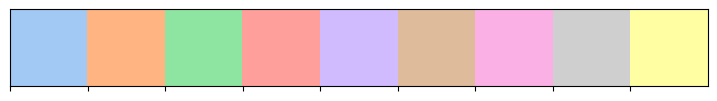

In [4]:
my_palette = sns.color_palette("pastel", 9)

sns.palplot(my_palette)

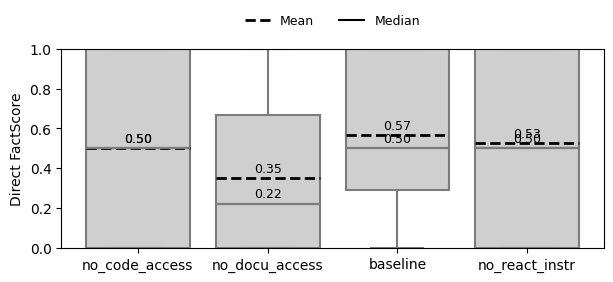

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

plt.figure(figsize=(7, 3.5))

# Draw boxplot
ax = sns.boxplot(
    data=df,
    x="ablation_type",
    y="fact_score.direct_fact_score",
    color=my_palette[7],
    showfliers=False,
    linewidth=1.5,
)

# X-tick metadata
xticks = ax.get_xticks()
xticklabels = [tick.get_text() for tick in ax.get_xticklabels()]

# Compute stats
means = df.groupby("ablation_type")["fact_score.direct_fact_score"].mean()
medians = df.groupby("ablation_type")["fact_score.direct_fact_score"].median()
pos_map = {label: pos for label, pos in zip(xticklabels, xticks)}

# Overlay mean/median lines + annotations
for ablation, pos in pos_map.items():
    mean_val = means.get(ablation)
    median_val = medians.get(ablation)

    if mean_val is not None:
        plt.hlines(
            mean_val, pos - 0.4, pos + 0.4, colors="black", linestyles="--", linewidth=2
        )
        plt.text(
            pos,
            mean_val + 0.015,
            f"{mean_val:.2f}",
            color="black",
            va="bottom",
            fontsize=9,
            ha="center",
        )

    if median_val is not None:
        plt.hlines(
            median_val,
            pos - 0.4,
            pos + 0.4,
            colors="black",
            linestyles="-",
            linewidth=1.5,
        )
        plt.text(
            pos,
            median_val + 0.015,
            f"{median_val:.2f}",
            color="black",
            va="bottom",
            fontsize=9,
            ha="center",
        )

# Final styling
plt.xlabel("")
plt.ylabel("Direct FactScore")
plt.ylim(0, 1)

# Top-centered legend without frame
ax.legend(
    handles=[
        plt.Line2D([0], [0], color="black", linestyle="--", linewidth=2, label="Mean"),
        plt.Line2D(
            [0], [0], color="black", linestyle="-", linewidth=1.5, label="Median"
        ),
    ],
    loc="lower center",
    bbox_to_anchor=(0.5, 1.05),
    fontsize=9,
    frameon=False,
    ncol=2,
)

# Add margin for legend
plt.subplots_adjust(top=0.82, bottom=0.25)
plt.show()

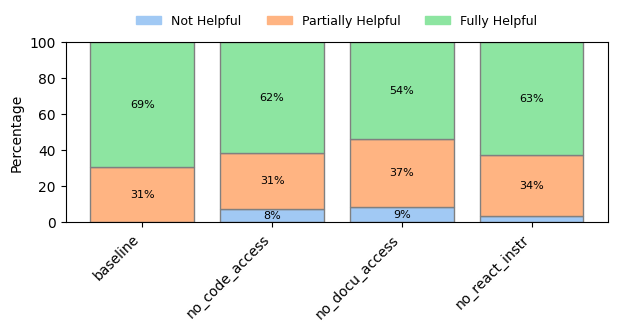

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Group and count by ablation_type instead of experiment_name
stacked_data = (
    df.groupby(["ablation_type", "agent_judge_outcome"]).size().unstack(fill_value=0)
)

# Desired outcome stacking order
desired_order = ["Not Helpful", "Partially Helpful", "Fully Helpful"]
stacked_data = stacked_data[desired_order]

# Convert to percentages row-wise
stacked_percent = stacked_data.div(stacked_data.sum(axis=1), axis=0) * 100

# Plot
fig, ax = plt.subplots(figsize=(7, 4))
bottom = [0] * len(stacked_percent)

for idx, outcome in enumerate(desired_order):
    values = stacked_percent[outcome].values
    bars = ax.bar(
        stacked_percent.index,
        values,
        bottom=bottom,
        label=outcome,
        color=my_palette[idx],
        edgecolor="gray",
    )

    # Annotate with percent labels (skip small segments)
    for i, (val, btm) in enumerate(zip(values, bottom)):
        if val >= 5:
            ax.text(
                i,
                btm + val / 2,
                f"{val:.0f}%",
                ha="center",
                va="center",
                fontsize=8,
                color="black",
            )

    bottom = [btm + val for btm, val in zip(bottom, values)]

# X-axis labels
ax.set_xticks(range(len(stacked_percent.index)))
ax.set_xticklabels(stacked_percent.index, rotation=45, ha="right")

# Legend above
legend_handles = [
    plt.Rectangle((0, 0), 1, 1, color=my_palette[i], label=label)
    for i, label in enumerate(desired_order)
]
ax.legend(
    handles=legend_handles,
    loc="lower center",
    bbox_to_anchor=(0.5, 1.02),
    fontsize=9,
    frameon=False,
    ncol=len(legend_handles),
)

# Adjust layout
fig.subplots_adjust(top=0.75, bottom=0.3)
plt.ylabel("Percentage")
plt.ylim(0, 100)
plt.show()

In [7]:
import pandas as pd

# ---- 1. Direct FactScore ----
direct_score_stats = (
    df.groupby("ablation_type")["fact_score.direct_fact_score"]
    .agg(["mean", "std"])
    .round(3)
)
direct_score_stats.columns = ["DirectScore_Mean", "DirectScore_Std"]

# ---- 2. Agent Judge Outcome Distribution ----
outcome_dist = (
    df.groupby(["ablation_type", "agent_judge_outcome"])
    .size()
    .unstack(fill_value=0)
    .div(df.groupby("ablation_type").size(), axis=0)
    .round(3)
    * 100
)
outcome_dist.columns = [
    f"Judge_{col.replace(' ', '')}_%" for col in outcome_dist.columns
]

# ---- 3. Input Tokens ----
token_stats = (
    df.groupby("ablation_type")["tokens_consumed.input_tokens"]
    .agg(["mean", "std"])
    .round(1)
)
token_stats.columns = ["InputTokens_Mean", "InputTokens_Std"]

# ---- 4. Execution Time ----
time_stats = (
    df.groupby("ablation_type")["excecution_time_seconds"].agg(["mean", "std"]).round(2)
)
time_stats.columns = ["Time_Mean_s", "Time_Std_s"]

# ---- 5. Combine all ----
summary_table = pd.concat(
    [direct_score_stats, outcome_dist, token_stats, time_stats], axis=1
)

# Optional: sort by DirectScore_Mean descending
summary_table = summary_table.sort_values("DirectScore_Mean", ascending=False)

# Display
summary_table

,DirectScore_Mean,DirectScore_Std,Judge_FullyHelpful_%,Judge_NotHelpful_%,Judge_PartiallyHelpful_%,InputTokens_Mean,InputTokens_Std,Time_Mean_s,Time_Std_s
ablation_type,,,,,,,,,
baseline,0.567,0.389,69.2,0.0,30.8,17201.7,10919.5,140.14,85.61
no_react_instr,0.526,0.400,62.6,3.3,34.1,23757.4,15075.3,119.25,75.46
no_code_access,0.502,0.405,61.5,7.7,30.8,18866.3,13891.3,84.46,65.67
no_docu_access,0.351,0.392,53.8,8.8,37.4,18191.4,21394.4,60.63,61.90
